## Modelo Base

En este notebook, estableceremos nuestro punto de partida para la modelización predictiva en nuestro proyecto. El objetivo principal es construir y evaluar un modelo base utilizando un Dummy Classifier. Este enfoque nos permitirá establecer una línea base para el rendimiento, la cual es crucial para evaluar la eficacia de modelos más avanzados posteriormente.

Un Dummy Classifier es un tipo de modelo que no aprende nada de los datos. Realiza predicciones utilizando reglas simples y no informadas, como predecir la clase más frecuente o generar predicciones aleatorias. Aunque suena contraproducente, este modelo juega un papel fundamental en la construcción de sistemas predictivos. Nos ayuda a comprender el mínimo rendimiento que cualquier otro modelo debería superar para ser considerado útil.

Importamos las librerías que necesitamos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scikitplot as skplt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import ConfusionMatrixDisplay

Definimos una función que evalúa el modelo. Esta funcion nos devuelve el Roc-Auc Score del modelo si se incluye las prediciones de las probabilidades y tambien nos devuelve el accuracy así como un classification_report con métricas como la precisón, el recall, el f1 entre otras.

In [2]:
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

Importamos los datos que necesitaremos utilizar.

In [3]:
with open('../data/X_train_val.pickle', 'rb') as file:
    X_train_val = pickle.load(file)

with open('../data/y_train_val.pickle', 'rb') as file:
    y_train_val = pickle.load(file)

with open('../data/X_val.pickle', 'rb') as file:
    X_val = pickle.load(file)

with open('../data/y_val.pickle', 'rb') as file:
    y_val = pickle.load(file)


Configuramos y entrenamos un modelo básico, conocido como Dummy Classifier, el cual predice la clase más frecuente en un conjunto de datos. Este modelo sirve como punto de referencia inicial, estableciendo el nivel más básico de rendimiento que cualquier modelo más sofisticado debería superar.

In [4]:
classifier = DummyClassifier(strategy = 'most_frequent', random_state = 12345)

In [5]:
dummy_model = Pipeline(steps=[
    ('classifier',  classifier)
])

In [6]:
dummy_model.fit(X_train_val,y_train_val)

Pipeline(steps=[('classifier',
                 DummyClassifier(random_state=12345,
                                 strategy='most_frequent'))])

Generamos las predicciones directas de la clase objetivo para cada muestra en el conjunto de validación. Luego, obtenemos las probabilidades de pertenencia a cada clase posible para estas mismas muestras. Esto proporciona tanto una predicción categórica (la clase más probable) como una medida de certeza o probabilidad asociada a cada predicción, lo cual es útil para entender mejor cómo el modelo está funcionando y para posibles evaluaciones más detalladas de su rendimiento.

In [7]:
pred = dummy_model.predict(X_val)
pred_proba = dummy_model.predict_proba(X_val)

Evaluamos el modelo.

In [8]:
evaluate_model(y_val, pred)


Accuracy of the model: 0.98896875

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    158235
           1       0.00      0.00      0.00      1765

    accuracy                           0.99    160000
   macro avg       0.49      0.50      0.50    160000
weighted avg       0.98      0.99      0.98    160000




La interpretación de las métricas revela una situación común al trabajar con un modelo base como el Dummy Classifier: el rendimiento extremadamente desigual entre las clases. Este modelo está diseñado para predecir siempre la clase más frecuente, y por lo tanto, tiene un alto rendimiento para la clase dominante (clase 0 en este caso) y un rendimiento nulo para la clase minoritaria (clase 1). La alta precisión general del modelo se debe a la abrumadora presencia de la clase 0 en los datos, lo que no es indicativo de un buen rendimiento del modelo en tareas reales de clasificación.

Es importante recalcar que estas métricas están en línea con lo esperado para un Dummy Classifier y sirven para establecer una línea de base muy básica. Cualquier modelo posterior que se desarrolle deberá superar significativamente estas métricas para ser considerado valioso, especialmente en términos de precisión y recall para la clase minoritaria, la cual es completamente ignorada por el Dummy Classifier. Este enfoque nos ayuda a establecer el mínimo umbral de rendimiento y a ilustrar la necesidad de técnicas más sofisticadas para manejar desequilibrios de clases y mejorar la precisión en la predicción de todas las categorías.

Realizamos las matrices de confusión, normalizada y sin normalizar.

Confusion matrix, without normalization
[[158235      0]
 [  1765      0]]


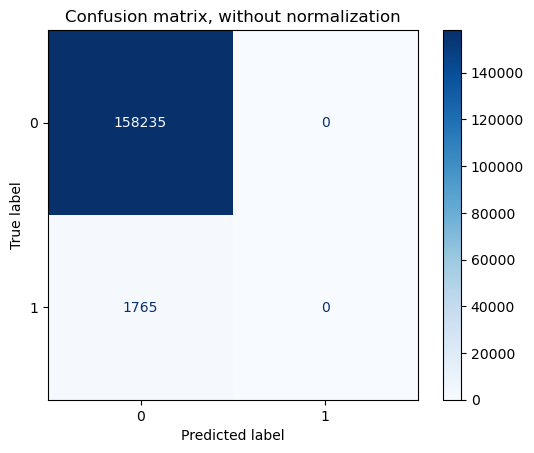

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


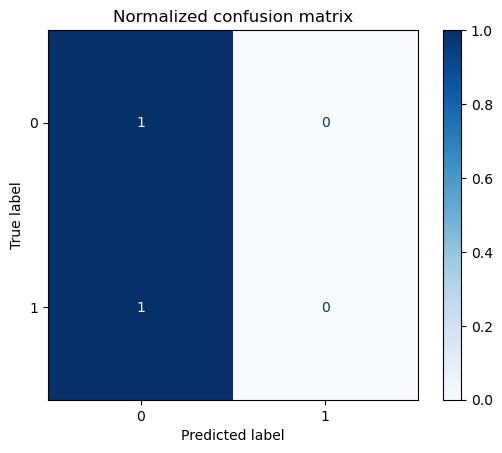

In [9]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dummy_model, X_val, y_val, 
        display_labels=dummy_model.classes_, 
        cmap=plt.cm.Blues, 
        normalize=normalize
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    plt.show()

La matriz superior, que no está normalizada, muestra el número absoluto de predicciones en cada categoría. En ella, podemos ver que el modelo predijo correctamente todos los casos de la clase 0 (158235 casos), que es la clase más frecuente. No hubo errores en la clase 0, pero tampoco hubo intentos de predecir la clase 1, dejando a los 1765 casos de la clase 1 incorrectamente clasificados como clase 0.

La matriz inferior es una versión normalizada de la matriz de confusión, la cual muestra las mismas predicciones pero en términos de proporciones en lugar de números absolutos. Esta matriz revela que el modelo tiene una tasa de acierto del 100% para la clase 0 y del 0% para la clase 1, reflejando que el modelo no tiene la capacidad de distinguir entre las clases en absoluto y siempre predice la clase 0.

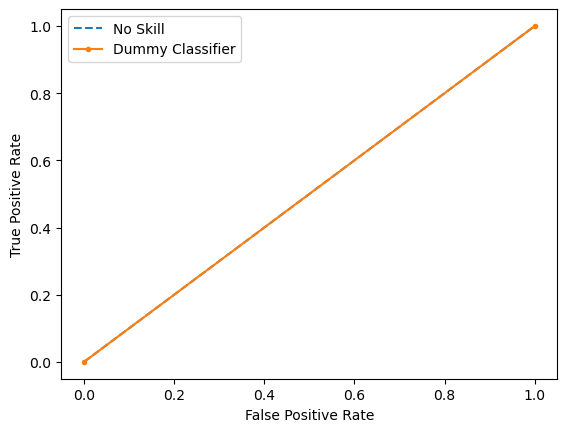

In [10]:
yhat = pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, yhat)

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Dummy Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

Nuestro modelo no tiene capacidad de predicción, por lo que la curva ROC es una línea recta.

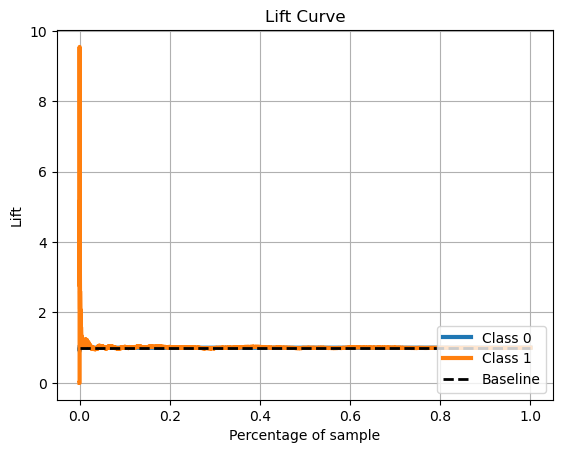

In [11]:
skplt.metrics.plot_lift_curve(y_val, pred_proba)
plt.show()

Las curvas de las clases 0 y 1 están adheridas muy cerca de la línea base, lo cual podría parecer preocupante a primera vista si esperáramos un alto rendimiento. Sin embargo, este patrón es completamente normal y esperado para un modelo base. Los modelos base  proporcionan un punto de comparación  que cualquier otro modelo debe aspirar a superar. La adherencia de las curvas a la línea base simplemente refleja que el modelo está realizando predicciones según la distribución más frecuente de las clases. Idealmente, querríamos que la curva de cada clase se aleje lo más posible de la línea base para indicar un buen rendimiento del modelo.

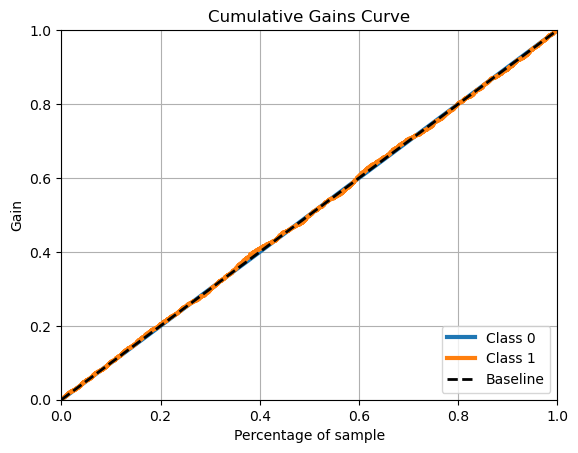

In [12]:
skplt.metrics.plot_cumulative_gain(y_val, pred_proba)
plt.show()

En un escenario ideal, querríamos que las curvas para cada clase se desviaran positivamente de la línea base para indicar un buen rendimiento. Sin embargo, las curvas de ambas clases (Clase 0 y Clase 1) se superponen perfectamente con la línea base.

La superposición perfecta indica que el modelo no tiene ningún poder predictivo más allá de elegir siempre la clase más frecuente.

Guardamos el modelo en un pickle

In [13]:
with open('../models/dummyclassifier.pickle', 'wb') as f:
    pickle.dump(dummy_model, f)